In [2]:
from SDP_interaction_inference.constraints import Constraint
from SDP_interaction_inference import optimization
from SDP_interaction_inference.dataset import Dataset
from SDP_interaction_inference.correlation import Correlation
from SDP_interaction_inference import utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import scipy
import tqdm
from copy import deepcopy
import matplotlib.patches
import corner
import plotly
import plotly.graph_objects as go

# Model Free Investigation

## Data Loading

In [3]:
# read fibroblast transcript counts
data_FIB = pd.read_csv("../../Real-Data/Datasets/GSE151334_FIB_counts_thresh.csv", index_col=0)

# remove outlying cell
data_FIB = data_FIB.drop(labels=['Fibroblasts_P23_S383'], axis=1)

# read RNA types
biotypes_dict = json.load(open("../../Real-Data/Datasets/GSE151334_RNA_types_thresh.json"))
biotypes_dict = {int(i): btype for i, btype in biotypes_dict.items()}
biotypes = [btype for btype in biotypes_dict.values()]

# select indices of protein coding (~mRNA) and non-coding miRNA
pcRNA_indices = [idx for idx, val in enumerate(biotypes) if val == "protein_coding"]
miRNA_indices = [idx for idx, val in enumerate(biotypes) if val == "miRNA"]

# separate data
data_FIB_pcRNA = data_FIB.iloc[pcRNA_indices]
data_FIB_miRNA = data_FIB.iloc[miRNA_indices]

# amounts: see './Biotypes/updated-biotypes.ipynb' for full pie chart of types
print(f"Total of {data_FIB.shape[0]} genes with mean > 1 present \nSelected {data_FIB_miRNA.shape[0]} non-coding miRNA \nSelected {data_FIB_pcRNA.shape[0]} protein coding (mRNA)")

Total of 11901 genes with mean > 1 present 
Selected 18 non-coding miRNA 
Selected 9376 protein coding (mRNA)


## Estimate Capture

In [4]:
def estimate_capture_baynorm(df, beta_mean=0.1):

    # set mean beta
    MeanBETA = beta_mean

    #xx<-Matrix::colSums(Data)
    xx = df.sum(axis='rows')

    #Normcount <- t_sp(t_sp(Data)/xx) * mean(xx)
    # Normcount <- Matrix::t(Matrix::t(Data)/xx) * mean(xx)
    Normcount = (df / xx) * np.mean(xx) # sum = mean(xx) per column

    #means <- Matrix::rowMeans(Normcount)
    means = Normcount.mean(axis='columns')

    #lmeans <- log(means)
    lmean = np.log(means)

    #med <- apply(log(Normcount + 1), 1, function(x) {
    #    median(x)
    #})
    med = np.log(Normcount + 1).median(axis=1)

    #mad <- apply(log(Normcount + 1), 1, function(x) {
    #    mad(x)
    #})
    mad = np.log(Normcount + 1).apply(lambda row: (row - row.median()).abs().median(), axis=1)

    #bound <- med + 3 * mad
    bound = med + 3*mad

    #maxlogGene <- apply(log(Normcount + 1), 1, max)
    maxlogGene = np.log(Normcount + 1).max(axis=1)

    #ind <- which(maxlogGene < bound)
    ind = maxlogGene < bound

    #dropout = apply(Data, 1, function(x) {
    #    length(which(x == 0))/length(x)
    #})
    dropout = df.apply(lambda row: (row == 0).sum() / row.size, axis=1)


    #Select_ind <- intersect(ind, which(dropout < 0.35))
    Select_ind = ind & (dropout < 0.35)

    # Selected_genes <- rownames(Data)[Select_ind]
    Selected_genes = list(Select_ind.index)

    #temppp <- Matrix::colSums(Data[Select_ind, ])
    temppp = df[Select_ind].sum(axis=0)

    #BETA <- temppp/mean(temppp) * MeanBETA
    BETA = (temppp / temppp.mean()) * MeanBETA

    #if (length(which(BETA >= 1)) > 0) {
    #    BETA[BETA >= 1] = max(BETA[BETA < 1])
    #}
    #if (length(which(BETA <= 0)) > 0) {
    #    BETA[BETA <= 0] = min(BETA[BETA > 0])
    #}
    if (BETA >= 1).size > 0:
        BETA[BETA >= 1] = BETA[BETA < 1].max()
    if (BETA <= 0).size > 0:
        BETA[BETA <= 0] = BETA[BETA > 0].min()

    #names(BETA) <- colnames(Data)

    #return(list(BETA = BETA, Selected_genes = Selected_genes))
    BETA = BETA.to_numpy()
    
    return BETA

In [5]:
def estimate_capture_basic(df, beta_mean=0.1):

    total_cell_counts = df.sum(axis='rows')
    total_counts_mean = total_cell_counts.mean()
    beta_basic = np.array(total_cell_counts / total_counts_mean) * beta_mean
    
    return beta_basic

In [6]:
# Estimate capture: Python BayNorm method & Basic total cell count scaling
beta = estimate_capture_baynorm(data_FIB)
beta_basic = estimate_capture_basic(data_FIB)

c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0.98, 'Comparison of capture estimation methods: BayNorm vs Basic')

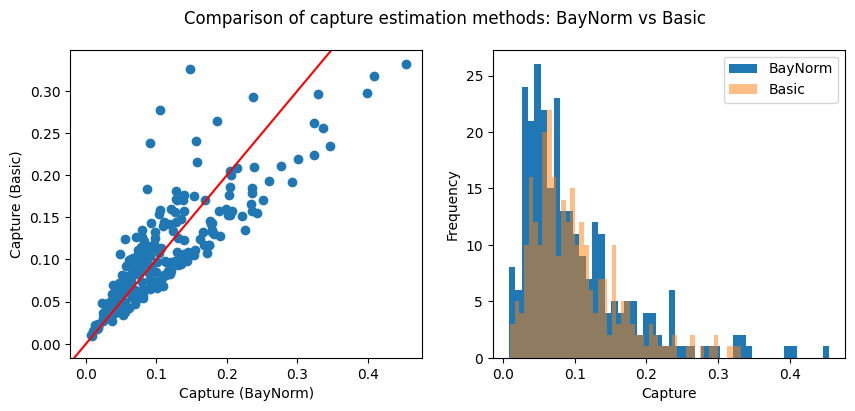

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].scatter(beta, beta_basic)
axs[0].axline([0, 0], [0.1, 0.1], color="red")
axs[0].set_xlabel("Capture (BayNorm)")
axs[0].set_ylabel("Capture (Basic)")
axs[1].hist(beta, label="BayNorm", bins=50)
axs[1].hist(beta_basic, alpha=0.5, label="Basic", bins=50)
axs[1].set_xlabel("Capture")
axs[1].set_ylabel("Frequency")
axs[1].legend()
plt.suptitle("Comparison of capture estimation methods: BayNorm vs Basic")

In [8]:
# Run BayNorm in R and save beta dict
beta_read = []
with open("beta.txt", "r") as file:
    for i, line in enumerate(file):
        if i % 2:
            vals = [float(x) for x in line.rstrip().split(' ') if x != '']
            beta_read += vals
beta_read = np.array(beta_read)

Text(0.5, 0.98, 'Comparison to actual R BayNorm')

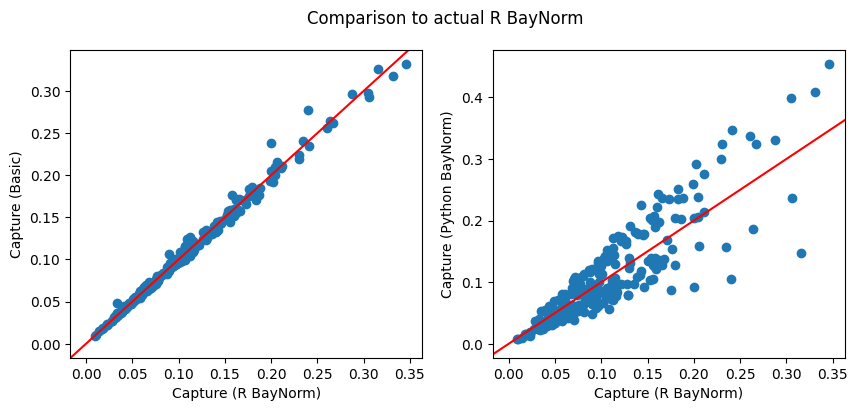

In [9]:
# very similar to basic method
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].scatter(beta_read, beta_basic)
axs[0].set_xlabel("Capture (R BayNorm)")
axs[0].set_ylabel("Capture (Basic)")
axs[0].axline([0, 0], [0.1, 0.1], color="red")
axs[1].scatter(beta_read, beta)
axs[1].set_xlabel("Capture (R BayNorm)")
axs[1].set_ylabel("Capture (Python BayNorm)")
axs[1].axline([0, 0], [0.1, 0.1], color="red")
plt.suptitle("Comparison to actual R BayNorm")

- Unsure the issue with the Python converted BayNorm method
- Basic method seems fine to use
- Try using Loaded baynorm for now

## Setup functions

In [10]:
def construct_dataset(mirna_sample, mrna_dataset, beta, resamples=1000):

    # size
    gene_pairs, cells = mrna_dataset.shape

    # construct paired count dataframe
    counts_df = pd.DataFrame(
        index = [f"Gene-pair-{i}" for i in range(gene_pairs)],
        columns = [f"Cell-{j}" for j in range(cells)]
    )

    # fill with pairs
    for i in range(gene_pairs):
        gene_i = mirna_sample
        gene_j = mrna_dataset.iloc[i]
        gene_pair_ij = list(zip(gene_i, gene_j))
        counts_df.iloc[i] = gene_pair_ij

    # construct dataset object
    data = Dataset()
    data.count_dataset = counts_df
    data.cells = cells
    data.gene_pairs = gene_pairs

    # settings
    data.resamples = resamples

    # set capture
    data.beta = beta

    return data

In [11]:
def model_free_independence_test(dataset, d, **kwargs):

    # Independent model free
    constraints = Constraint(
        moment_bounds=True,
        moment_matrices=True,
        factorization=True
    )
    opt_MF_ind = optimization.ModelFreeOptimization(dataset, d, constraints=constraints, printing=False, silent=True, **kwargs)
    opt_MF_ind.analyse_dataset()

    # extract results
    status = [solution['status'] for solution in opt_MF_ind.result_dict.values()]
    times  = [solution['time'] for solution in opt_MF_ind.result_dict.values()]
    cuts   = [solution['cuts'] for solution in opt_MF_ind.result_dict.values()]

    # collect
    data = {
        'status': status,
        'times': times,
        'cuts': cuts,
        'model': opt_MF_ind
    }

    return data

In [12]:
def model_free_interacting_test(dataset, d, **kwargs):

    # Interacting model free
    constraints = Constraint(
        moment_bounds=True,
        moment_matrices=True,
        factorization=False
    )
    opt_MF_int = optimization.ModelFreeOptimization(dataset, d, constraints=constraints, printing=False, silent=True, **kwargs)
    opt_MF_int.analyse_dataset()

    # extract results
    status = [solution['status'] for solution in opt_MF_int.result_dict.values()]
    times  = [solution['time'] for solution in opt_MF_int.result_dict.values()]
    cuts   = [solution['cuts'] for solution in opt_MF_int.result_dict.values()]
    correlation = [solution['correlation'] for solution in opt_MF_int.result_dict.values()]

    # collect
    data = {
        'status': status,
        'times': times,
        'cuts': cuts,
        'correlation': correlation,
        'model': opt_MF_int
    }

    return data

## Setup results

### Construct

In [13]:
# select mRNA
mRNA = data_FIB_pcRNA.index

In [ ]:
# dataframe to store model free results
#MF_independent_df = pd.DataFrame(
#    index=mRNA
#)
#MF_interacting_df = pd.DataFrame(
#    index=mRNA
#)

### Load

In [ ]:
#MF_independent_df = pd.read_csv("Results/independent_MF.csv", index_col=0)
#MF_interacting_df = pd.read_csv("Results/interacting_MF.csv", index_col=0)

### Save

In [ ]:
#MF_independent_df.to_csv("Results/independent_MF.csv")
#MF_interacting_df.to_csv("Results/interacting_MF.csv")

## Running

In [ ]:
# for each miRNA
miRNA_names = data_FIB_miRNA.index
for miRNA in miRNA_names:

    # display miRNA
    print(f"\nRunning {miRNA}")

    # construct dataset of miRNA paired with mRNA
    dataset_SDP = construct_dataset(data_FIB_miRNA.loc[miRNA], data_FIB_pcRNA, beta_read)

    # bootstrap
    print("Bootstrap:")
    dataset_SDP.confidence = 0.95
    dataset_SDP.bootstrap(d=4, tqdm_disable=False)

    # independence test
    print("MF Independence test:")
    MF_ind_d4_c95 = model_free_independence_test(dataset_SDP, d=4, time_limit=30, total_time_limit=30)

    # display results
    print(np.unique(MF_ind_d4_c95['status'], return_counts=True))

    # interacting test
    print("MF Interacting test:")
    MF_int_d4_c95 = model_free_interacting_test(dataset_SDP, d=4, time_limit=30, total_time_limit=30)

    # display results
    print(np.unique(MF_int_d4_c95['status'], return_counts=True))

    # store results on dataframe

    # independence test
    MF_independent_df[f'{miRNA}_d4_c95_status'] = MF_ind_d4_c95['status']
    MF_independent_df[f'{miRNA}_d4_c95_times'] = MF_ind_d4_c95['times']
    MF_independent_df[f'{miRNA}_d4_c95_cuts'] = MF_ind_d4_c95['cuts']

    # interacting test
    MF_interacting_df[f'{miRNA}_d4_c95_status'] = MF_int_d4_c95['status']
    MF_interacting_df[f'{miRNA}_d4_c95_times'] = MF_int_d4_c95['times']
    MF_interacting_df[f'{miRNA}_d4_c95_cuts'] = MF_int_d4_c95['cuts']
    MF_interacting_df[f'{miRNA}_d4_c95_correlation'] = MF_int_d4_c95['correlation']

    # save dataframes as safety
    #MF_independent_df.to_csv("Results/independent_MF.csv")  # Uncomment when running
    #MF_interacting_df.to_csv("Results/interacting_MF.csv")


Running MIR100
Bootstrap:


100%|██████████| 9376/9376 [05:57<00:00, 26.25it/s]


MF Independence test:


100%|██████████| 9376/9376 [08:40<00:00, 18.02it/s]


(array(['CUT_LIMIT', 'INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([  10, 1926, 7440]))
MF Interacting test:


100%|██████████| 9376/9376 [10:08<00:00, 15.40it/s]


(array(['CUT_LIMIT', 'INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([1120,   68, 8188]))

Running MIR103A2
Bootstrap:


100%|██████████| 9376/9376 [05:38<00:00, 27.69it/s]


MF Independence test:


100%|██████████| 9376/9376 [09:59<00:00, 15.63it/s]


(array(['CUT_LIMIT', 'INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([  84, 2964, 6328]))
MF Interacting test:


100%|██████████| 9376/9376 [10:03<00:00, 15.54it/s]


(array(['CUT_LIMIT', 'INFEASIBLE', 'NUMERIC', 'OPTIMAL'], dtype='<U10'), array([1355,   75,    1, 7945]))

Running MIR16-2
Bootstrap:


100%|██████████| 9376/9376 [05:32<00:00, 28.20it/s]


MF Independence test:


100%|██████████| 9376/9376 [09:01<00:00, 17.31it/s]


(array(['CUT_LIMIT', 'INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([   7,  916, 8453]))
MF Interacting test:


100%|██████████| 9376/9376 [10:53<00:00, 14.34it/s]  


(array(['CUT_LIMIT', 'INFEASIBLE', 'OPTIMAL', 'TIME_LIMIT'], dtype='<U10'), array([1603,   58, 7714,    1]))

Running MIR199A1
Bootstrap:


100%|██████████| 9376/9376 [05:31<00:00, 28.28it/s]


MF Independence test:


100%|██████████| 9376/9376 [08:29<00:00, 18.40it/s]


(array(['CUT_LIMIT', 'INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([   7, 3306, 6063]))
MF Interacting test:


100%|██████████| 9376/9376 [10:52<00:00, 14.36it/s]


(array(['CUT_LIMIT', 'INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([1624,   71, 7681]))

Running MIR199A2
Bootstrap:


100%|██████████| 9376/9376 [05:31<00:00, 28.28it/s]


MF Independence test:


100%|██████████| 9376/9376 [08:59<00:00, 17.37it/s]


(array(['CUT_LIMIT', 'INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([  21, 1859, 7496]))
MF Interacting test:


100%|██████████| 9376/9376 [10:23<00:00, 15.04it/s]


(array(['CUT_LIMIT', 'INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([1119,   76, 8181]))

Running MIR221
Bootstrap:


100%|██████████| 9376/9376 [05:40<00:00, 27.56it/s]


MF Independence test:


100%|██████████| 9376/9376 [08:55<00:00, 17.52it/s]


(array(['CUT_LIMIT', 'INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([   8, 1588, 7780]))
MF Interacting test:


100%|██████████| 9376/9376 [10:07<00:00, 15.43it/s]


(array(['CUT_LIMIT', 'INFEASIBLE', 'NUMERIC', 'OPTIMAL'], dtype='<U10'), array([ 985,   71,    1, 8319]))

Running MIR222
Bootstrap:


100%|██████████| 9376/9376 [05:45<00:00, 27.17it/s]


MF Independence test:


100%|██████████| 9376/9376 [09:30<00:00, 16.44it/s]


(array(['CUT_LIMIT', 'INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([   5,  607, 8764]))
MF Interacting test:


100%|██████████| 9376/9376 [11:43<00:00, 13.33it/s]


(array(['CUT_LIMIT', 'INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([2516,   70, 6790]))

Running MIR23A
Bootstrap:


100%|██████████| 9376/9376 [05:43<00:00, 27.29it/s]


MF Independence test:


100%|██████████| 9376/9376 [09:43<00:00, 16.07it/s]


(array(['CUT_LIMIT', 'INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([  20,  812, 8544]))
MF Interacting test:


100%|██████████| 9376/9376 [11:33<00:00, 13.52it/s]


(array(['CUT_LIMIT', 'INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([1629,   74, 7673]))

Running MIR24-2
Bootstrap:


100%|██████████| 9376/9376 [05:34<00:00, 28.05it/s]


MF Independence test:


100%|██████████| 9376/9376 [09:09<00:00, 17.06it/s]


(array(['CUT_LIMIT', 'INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([  15, 1088, 8273]))
MF Interacting test:


100%|██████████| 9376/9376 [10:58<00:00, 14.23it/s]


(array(['CUT_LIMIT', 'INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([1672,   62, 7642]))

Running MIR27A
Bootstrap:


100%|██████████| 9376/9376 [05:31<00:00, 28.28it/s]


MF Independence test:


100%|██████████| 9376/9376 [09:07<00:00, 17.11it/s]


(array(['CUT_LIMIT', 'INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([  17,  718, 8641]))
MF Interacting test:


100%|██████████| 9376/9376 [10:33<00:00, 14.79it/s]


(array(['CUT_LIMIT', 'INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([1687,   69, 7620]))

Running MIR29A
Bootstrap:


100%|██████████| 9376/9376 [05:30<00:00, 28.35it/s]


MF Independence test:


100%|██████████| 9376/9376 [09:50<00:00, 15.89it/s]


(array(['CUT_LIMIT', 'INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([  37, 1695, 7644]))
MF Interacting test:


100%|██████████| 9376/9376 [10:12<00:00, 15.30it/s]


(array(['CUT_LIMIT', 'INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([1005,   71, 8300]))

Running MIR31
Bootstrap:


100%|██████████| 9376/9376 [05:33<00:00, 28.11it/s]


MF Independence test:


100%|██████████| 9376/9376 [08:40<00:00, 18.00it/s]


(array(['CUT_LIMIT', 'INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([   4, 2387, 6985]))
MF Interacting test:


100%|██████████| 9376/9376 [10:21<00:00, 15.10it/s]


(array(['CUT_LIMIT', 'INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([1198,   75, 8103]))

Running MIR3609
Bootstrap:


100%|██████████| 9376/9376 [05:31<00:00, 28.26it/s]


MF Independence test:


100%|██████████| 9376/9376 [10:16<00:00, 15.20it/s]


(array(['CUT_LIMIT', 'INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([  85, 1646, 7645]))
MF Interacting test:


100%|██████████| 9376/9376 [10:38<00:00, 14.68it/s]


(array(['CUT_LIMIT', 'INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([2274,   77, 7025]))

Running MIR4449
Bootstrap:


100%|██████████| 9376/9376 [05:30<00:00, 28.41it/s]


MF Independence test:


100%|██████████| 9376/9376 [11:50<00:00, 13.19it/s]


(array(['CUT_LIMIT', 'INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([ 246, 1408, 7722]))
MF Interacting test:


100%|██████████| 9376/9376 [11:52<00:00, 13.16it/s]  


(array(['CUT_LIMIT', 'INFEASIBLE', 'OPTIMAL', 'TIME_LIMIT'], dtype='<U10'), array([1584,   81, 7710,    1]))

Running MIR877
Bootstrap:


100%|██████████| 9376/9376 [05:31<00:00, 28.29it/s]


MF Independence test:


100%|██████████| 9376/9376 [08:53<00:00, 17.59it/s]


(array(['CUT_LIMIT', 'INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([  12, 1122, 8242]))
MF Interacting test:


100%|██████████| 9376/9376 [10:57<00:00, 14.26it/s]


(array(['CUT_LIMIT', 'INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([1655,   74, 7647]))

Running MIRLET7A1
Bootstrap:


100%|██████████| 9376/9376 [05:30<00:00, 28.37it/s]


MF Independence test:


100%|██████████| 9376/9376 [08:41<00:00, 17.99it/s]


(array(['CUT_LIMIT', 'INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([   4, 2090, 7282]))
MF Interacting test:


100%|██████████| 9376/9376 [10:46<00:00, 14.49it/s]


(array(['CUT_LIMIT', 'INFEASIBLE', 'NUMERIC', 'OPTIMAL'], dtype='<U10'), array([1546,   62,    1, 7767]))

Running MIRLET7A2
Bootstrap:


100%|██████████| 9376/9376 [05:34<00:00, 28.01it/s]


MF Independence test:


100%|██████████| 9376/9376 [08:39<00:00, 18.06it/s]


(array(['CUT_LIMIT', 'INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([   3, 2399, 6974]))
MF Interacting test:


100%|██████████| 9376/9376 [11:54<00:00, 13.13it/s]


(array(['CUT_LIMIT', 'INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([1356,   74, 7946]))

Running MIRLET7D
Bootstrap:


100%|██████████| 9376/9376 [06:37<00:00, 23.57it/s]


MF Independence test:


100%|██████████| 9376/9376 [10:15<00:00, 15.23it/s]


(array(['CUT_LIMIT', 'INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([  13, 1696, 7667]))
MF Interacting test:


 71%|███████   | 6671/9376 [08:16<04:10, 10.78it/s]c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\SDP_interaction_inference\optimization_utils.py:615: RuntimeWarning: invalid value encountered in sqrt
  correlation = cov_xy / (np.sqrt(var_x) * np.sqrt(var_y))
100%|██████████| 9376/9376 [11:38<00:00, 13.42it/s]


(array(['CUT_LIMIT', 'INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([1579,   87, 7710]))


## Notes

- some NUMERIC status
- varying levels of dependence
- overall a lot of CUT_LIMIT for interacting test, and some INFEASIBLE

- check how big an impact beta vs beta_read has